### Importation des données avec la machine des snapchots

In [1]:
# J'ai besoin de ces 3 packages
# Pour faire des figures
import matplotlib.pyplot as plt
# Pour faire des matrices
import numpy as np
# Pour faire de la DMD
from pydmd import DMDc
from sklearn.metrics import mean_squared_error

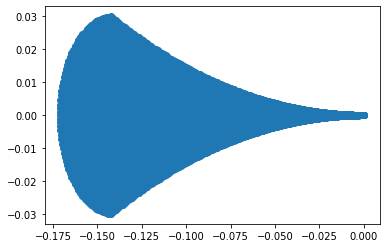

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pyvista as pv


# Some important time parameters from the HF simulation
n_snapshots = 200 
dt = 1 # PAS DE TEMPS
tfinal = 200
time = np.arange(0, tfinal, dt)

# Read the (x,y) mesh points (use just 1 VTU file because the mesh doesnt change with time)
file_name = '~/Documents/GitHub/Sujet 2/PROJET/DATA_LEARNING/output001.cont.pvtu'
position = pv.read(file_name).points
# Exemple de forme du maillage
plt.figure()
plt.scatter(position[:, 0], position[:, 1])
plt.show()

In [4]:
# Read the temperature field at each time step and create the snapshot matrix : here an example for the learning base
snapshot_temperature = []
data_visu = []
for it in range(n_snapshots):
    ii = '{:03.0f}'.format(it + 1)
    file_name = '~/Documents/GitHub/Sujet 2/PROJET/DATA_LEARNING/output' + str(ii) + '.cont.pvtu'
    data = pv.read(file_name)
    snapshot_temperature.append(data.point_data["T_Dim"])
    data_visu.append(data)
snapshot_temperature = np.array(snapshot_temperature).transpose()
print("The size of the snapshot matrix is: ", snapshot_temperature.shape)

The size of the snapshot matrix is:  (8385, 200)


### Partie visualisation

In [9]:
plotter = pv.Plotter()

template = pv.wrap(position)

def predict_time(it):
    it = int(it)
    template.point_data['T_Dim'] = snapshot_temperature[:,it]
    return

plotter.add_slider_widget(predict_time, [1, 200] , title='Time')

plotter.add_mesh(template, lighting=True, show_edges=False, texture=False, scalars='T_Dim', cmap='bwr', show_scalar_bar=True)
plotter.view_xy()

# Display the window 
plotter.show(full_screen=True)

ViewInteractiveWidget(height=864, layout=Layout(height='auto', width='100%'), width=1536)

### Début de la recherche de la base réduite

In [11]:
# Calcul de la matrice de corrélation
c = np.matmul(snapshot_temperature, snapshot_temperature.transpose())
# Calcul des valeurs propres et vecteurs propres de C
alpha, phi = np.linalg.eig(c)
alpha = alpha.real
phi = phi.real
# On garde pour tester n_mode = 99% de la variance expliquée
min_exp_var = 0.999
exp_var = alpha / np.sum(alpha)
cum_exp_var = np.cumsum(alpha) / np.sum(alpha)
n_mode = np.where(cum_exp_var > min_exp_var)[0][0] + 1

In [12]:
# Lorsque l'on considère que l'on doit avoir 99% de la variance expliquée nous devrions garder 1 mode

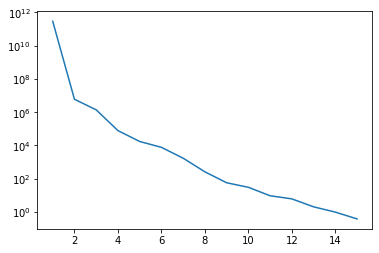

In [33]:
plt.plot(np.linspace(1,15,15),alpha.tolist()[0:15])
plt.yscale('log')
plt.show()
# Rapport d'envirion 1e5 entre la première et la seconde valeur propre
# Donc on remarque bien que la première valeur propre tire l'information avec elle

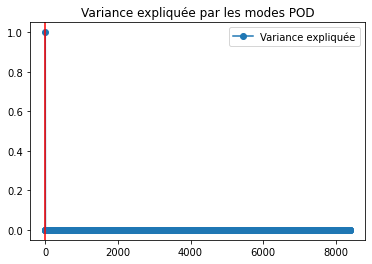

In [13]:
# Affichage de la courbe de la variance expliquée en fonction des modes
plt.figure()
plt.plot(exp_var, "o-", label="Variance expliquée")
plt.axvline(x=int(n_mode - 1), color="red")
plt.title("Variance expliquée par les modes POD")
plt.legend()
plt.show()

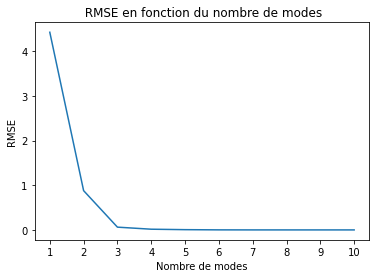

In [37]:
RMSE = []
n_mode_max = 10 # on a testé jusqu'à 10 modes de conservé
# On essayer avec différents modes 1,2,3,4,5
for n_mode in range (1,n_mode_max+1):
    
    # Calcul de la base
    nx = snapshot_temperature.shape[0] # 8385
    BasePod = np.zeros((nx, n_mode))
    for i in range(n_mode):
        BasePod[:, i] = phi[:, i]
        
    # Reconstruction des coefficients a_k(t) aux temps de sauvegarde des snapshots
    a_proj = np.zeros((n_mode, snapshot_temperature.shape[1]))
    for k in range(n_mode):
        for it in range(snapshot_temperature.shape[1]):
            for i in range(phi.shape[0]):
                a_proj[k, it] += BasePod[i, k] * snapshot_temperature[i, it]
                
    reconstructed_snapshot = np.dot(BasePod,a_proj)
    
    RMSE.append(mean_squared_error(snapshot_temperature, reconstructed_snapshot))
    
plt.plot(np.linspace(1,n_mode_max,n_mode_max),RMSE)
plt.xticks(np.linspace(1,n_mode_max,n_mode_max))
plt.title(" RMSE en fonction du nombre de modes")
plt.xlabel("Nombre de modes")
plt.ylabel("RMSE")
plt.show()

In [45]:
# On remarque assez facilement sur le graphique liant RMSE en fonction des modes 
# qu'il y a un coude se situant aux alentours de 3 modes

# En ce qui concerne la POD, nous avons fait le choix de concerver 3 modes 
n_mode = 3

In [46]:
# On calcul ici les vecteurs de la base POD avec 3 modes
nx = snapshot_temperature.shape[0] # 8385
BasePod = np.zeros((nx, n_mode))
for i in range(n_mode):
    BasePod[:, i] = phi[:, i]

In [47]:
# Reconstruction des coefficients a_k(t) aux temps de sauvegarde des snapshots
a_proj = np.zeros((n_mode, snapshot_temperature.shape[1]))
for k in range(n_mode):
    for it in range(snapshot_temperature.shape[1]):
        for i in range(phi.shape[0]):
            a_proj[k, it] += BasePod[i, k] * snapshot_temperature[i, it]

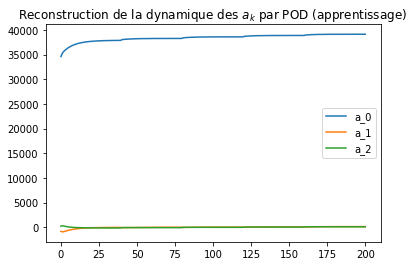

In [54]:
# Affichage des a_proj pour chaque mode
for p in range (n_mode):
    plt.plot(np.linspace(0,200,200),a_proj[p,:],label=f"a_{p}")
plt.title('Reconstruction de la dynamique des $a_k$ par POD (apprentissage)')
plt.legend()
plt.show()

In [51]:
# On reconstruit nos température grâce au modèle réduit POD
reconstructed_snapshot = np.dot(BasePod,a_proj)

In [52]:
print("MSE : ", mean_squared_error(snapshot_temperature, reconstructed_snapshot))

MSE :  0.06198239784778117


In [58]:
# Visualisation des températures

plotter = pv.Plotter(shape=(1, 2))
template_or = pv.wrap(position)
template_pred = pv.wrap(position)

def predict_time(it):
    it = int(it)
    template_or.point_data['T_Dim'] = snapshot_temperature[:,it]
    template_pred.point_data['T_Dim'] = reconstructed_snapshot[:,it]
    return

plotter.add_slider_widget(predict_time, [1, 200] , title='Time')

plotter.subplot(0,0)
plotter.add_text('Température obtenue par simulation')
plotter.add_mesh(template_or, lighting=True, show_edges=False, texture=False, scalars='T_Dim', cmap='bwr', show_scalar_bar=True)
plotter.view_xy()

plotter.subplot(0,1)
plotter.add_text('Température de prédiction avec la POD')
plotter.add_mesh(template_pred, lighting=True, show_edges=False, texture=False, scalars='T_Dim', cmap='bwr', show_scalar_bar=True)
plotter.view_xy()

# Display the window 
plotter.show(full_screen=True)



ViewInteractiveWidget(height=864, layout=Layout(height='auto', width='100%'), width=1536)

### Fin de POD

### Début de la DMDc

In [61]:
# On représente ici notre terme de commande (c'est à dire la vitesse) de la même forme que diap 11 du sujet

v_snapshot = np.concatenate([np.tile(0.5, 40), np.tile(0.6, 40), np.tile(0.7, 40), np.tile(0.8, 40), np.tile(0.9, 39)], axis=0)

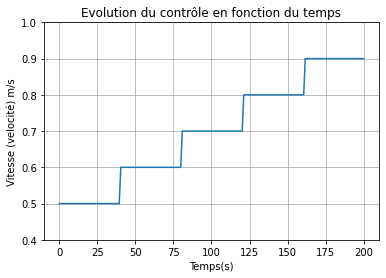

In [62]:
plt.plot(np.linspace(0,200,199),v_snapshot)
plt.title("Evolution du contrôle en fonction du temps")
plt.ylim(0.40,1)
plt.grid()
plt.xlabel("Temps(s)")
plt.ylabel("Vitesse (velocité) m/s")
plt.show()

In [81]:
dmdc = DMDc()
dmdc.fit(snapshot_temperature, v_snapshot)

In [85]:
dmdc.reconstructed_data()

array([[3.98165845e+02+0.00000000e+00j, 5.71679989e+04-1.42652526e-05j,
        1.69633302e+10-2.83834245e+00j, ...,
                   nan           +nanj,            nan           +nanj,
                   nan           +nanj],
       [3.98166186e+02+0.00000000e+00j, 5.68925817e+04-1.42663132e-05j,
        1.69732833e+10-2.84000797e+00j, ...,
                   nan           +nanj,            nan           +nanj,
                   nan           +nanj],
       [3.96033790e+02+0.00000000e+00j, 5.93163257e+04-1.44611998e-05j,
        1.72069652e+10-2.87910964e+00j, ...,
                   nan           +nanj,            nan           +nanj,
                   nan           +nanj],
       ...,
       [3.93436956e+02+0.00000000e+00j, 3.89892527e+04-1.00470075e-05j,
        1.18584621e+10-1.98418418e+00j, ...,
                   nan           +nanj,            nan           +nanj,
                   nan           +nanj],
       [3.93433439e+02+0.00000000e+00j, 3.89571817e+04-1.00357616e-0

In [67]:
plotter = pv.Plotter(shape=(1, 2))

template_or = pv.wrap(position)
template_pred = pv.wrap(position)

def predict_time(it):
    it = int(it)
    template_or.point_data['T_Dim'] = snapshot_temperature[:,it]
    template_pred.point_data['T_Dim'] = dmdc.reconstructed_data()[:,it]
    return

plotter.add_slider_widget(predict_time, [1, 200] , title='Time')

plotter.subplot(0,0)
plotter.add_text('Température obtenue par simulation')
plotter.add_mesh(template_or, lighting=True, show_edges=False, texture=False, scalars='T_Dim', cmap='bwr', show_scalar_bar=True)
plotter.view_xy()

plotter.subplot(0,1)
plotter.add_text('Température de prédiction par la DMDc ')
plotter.add_mesh(template_pred, lighting=True, show_edges=False, texture=False, scalars='T_Dim', cmap='bwr', show_scalar_bar=True)
plotter.view_xy()

# Display the window 
plotter.show(full_screen=True)


ViewInteractiveWidget(height=864, layout=Layout(height='auto', width='100%'), width=1536)

C:\ProgramData\Anaconda3\envs\Michelin\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'Reconstruction de la dynamique des $a_k$ par DMDc (apprentissage)')

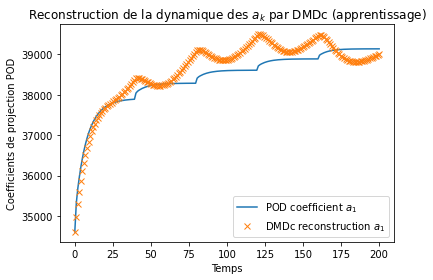

In [111]:
plt.figure()
plt.plot(np.linspace(0,200,200), a_proj[0, :], label='POD coefficient $a_1$')
plt.plot(np.linspace(0,200,200), dmdc.reconstructed_data()[0, :], 'x', label='DMDc reconstruction $a_1$')
plt.legend()
plt.xlabel('Temps')
plt.ylabel('Coefficients de projection POD')
plt.title('Reconstruction de la dynamique des $a_k$ par DMDc (apprentissage)')

In [107]:
dmdc.snapshots.shape

(3, 200)

In [108]:
reconstructed_snapshot[:,1]

array([408.05185323, 408.0514226 , 406.13449287, ..., 403.09665392,
       403.10339995, 403.2238145 ])

array([[390.1607774 , 398.2183156 , 402.37072122, ..., 441.15502804,
        441.15564309, 441.15619209],
       [390.16049696, 398.21802937, 402.37043201, ..., 441.15471094,
        441.155326  , 441.15587499],
       [389.10824824, 397.14404978, 401.28525353, ..., 439.96493267,
        439.96554607, 439.96609358],
       ...,
       [387.47743072, 395.47955288, 399.60340016, ..., 438.12096632,
        438.12157714, 438.12212236],
       [387.48508482, 395.48736505, 399.61129379, ..., 438.12962082,
        438.13023165, 438.13077689],
       [387.57468301, 395.57881361, 399.70369592, ..., 438.23092954,
        438.23154052, 438.23208588]])

In [74]:
for i in range(0,n_snapshots):
    # Vous lisez un pas de temps au hasard juste pour récupérer le maillage

    ii = '{:03.0f}'.format(it + 1)
    file_name = '~/Documents/GitHub/Sujet 2/PROJET/DATA_LEARNING/output' +str(ii) +'.cont.pvtu'
    template = pv.read(file_name)

    # Vous virez les champs presents à l’intérieur
    template.clear_point_arrays()

    # Vous venez créer un nouveau champ qui contiendra la prédiction de votre modèle
    template.point_arrays['T_POD'] = reconstructed_snapshot[:,i]
    template.save(f'TemperatureModeleReduit_time{i}.vtu')

# Vous pouvez répéter ça à chaque pas de temps et sauver donc un fichier VTU par pas de temps



# Ensuite c’est facile de visualiser la solution sur le maillage avec pyvista : ici pour un pas de temps
plotter = pv.Plotter()
plotter.add_mesh(template, lighting=True, show_edges=False, texture=False, scalars='T_POD', cmap='bwr',show_scalar_bar=True)
plotter.view_xy()
plotter.show(full_screen=True)

ViewInteractiveWidget(height=864, layout=Layout(height='auto', width='100%'), width=1536)

In [75]:
template

UnstructuredGrid (0x19728e42b28)
  N Cells:	3897
  N Points:	8385
  X Bounds:	-1.711e-01, 2.330e-04
  Y Bounds:	-2.998e-02, 2.998e-02
  Z Bounds:	0.000e+00, 0.000e+00
  N Arrays:	1